In [1]:
import pyexasol
import pandas as pd

pd.set_option("display.max_colwidth", None)
def printQuery(query, connection):
    stmt = connection.export_to_pandas(query)
    print(stmt.head())
    return stmt

# Connection parameters - change the fingerprint each time you start the database

host = '192.168.56.102/02EAE27A4FCBAFD70F1656B3C2DAC5ED1BD43CA582B851C280A53586FCA5318E:8563'  # Replace with your Exasol host (e.g., '192.168.0.100:8563')
user = 'sys'     # Replace with your Exasol username
password = 'exasol' # Replace with your Exasol password

# Connect to Exasol
conn = pyexasol.connect(dsn=host, user=user, password=password, debug=False, protocol_version=pyexasol.PROTOCOL_V1)

In [2]:
q = '''
SELECT QUERYDIM.QUERY, TIMEDIM.[month], TIMEDIM.[day of the month], (TIMEDIM.[day of the year] - 60) as DaysAfterDBStart, TIMEDIM.[hour], TIMEDIM.[minute], FACTS.QUERYID, FACTS.TIMEID, FACTS.ANONID, (TIMEDIM.[hour]*60 + TIMEDIM.[minute]) as MinutesAfterMidnight
FROM AOL_SCHEMA.QUERYDIM 
    LEFT JOIN AOL_SCHEMA.FACTS ON QUERYDIM.ID = FACTS.QUERYID
    LEFT JOIN AOL_SCHEMA.TIMEDIM ON QUERYDIM.ID = TIMEDIM.ID
    LEFT JOIN AOL_SCHEMA.URLDIM ON FACTS.URLID = URLDIM.ID
WHERE FACTS.CLICK = 1 AND URLDIM.URL = 'http://www.youtube.com'
    AND (QUERYDIM.QUERY IS NOT NULL
        AND TIMEDIM.[hour] IS NOT NULL
        AND TIMEDIM.[minute] IS NOT NULL
        AND TIMEDIM.[day of the year] IS NOT NULL
        AND QUERYDIM.QUERY NOT LIKE '%youtube%'
        AND QUERYDIM.QUERY NOT LIKE '%you tube%'
        AND QUERYDIM.QUERY NOT LIKE '%your tube%')
'''
# Select (see select clause) when the youtube link was clicked

df = printQuery(q, conn)
print(df.shape, df.columns, sep="\n")


                            QUERY      month  day of the month  \
0                     jake peyton  march                     1   
1             bush drinking video  april                    26   
2  cant stop scratching my vagina  april                    26   
3                      vid idiots  april                    19   
4                 naruto websites  may                       9   

   DAYSAFTERDBSTART  hour  minute  QUERYID   TIMEID  ANONID  \
0                 0     0      13  2775687  5962961  154767   
1                56     9      31  2778308  5986392   53322   
2                56     2      19  2774391  4104872  317691   
3                49    16       6  2785441  2778338  126651   
4                69    15      44  2787473  5086065    7725   

   MINUTESAFTERMIDNIGHT  
0                    13  
1                   571  
2                   139  
3                   966  
4                   944  
(2028, 10)
Index(['QUERY', 'month', 'day of the month', 'DAYSAFTERDB

In [3]:
listOfQueries = df['QUERY'].values.tolist()

In [4]:
listOfQueries[:5]

['jake peyton',
 'bush drinking video',
 'cant stop scratching my vagina',
 'vid idiots',
 'naruto websites']

## Text Classification Using BERT (Bidirectional Encoder Representation from Transformers)

- BERT is a bidirectional so, it read text in both directions making it able to capture the full context of the word based on its surrondings.
- BERT has parallel processing ability which allow it to process all words in sentence at once which makes it effective for large datasets.
- BERT processes tokenized input text and generates contextualized embeddings that capture the relationships between words based on the context.
- BERT embeddings are high-dimensional (usually 768 dimensions for bert-base), you might want to reduce the dimensionality to make clustering more efficient and interpretable.
- Use PCA for dimensionality reduction.
- Use DBSCAN to overcome the complexity of choosing cluster numbers in K means.

In [37]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Step 1: Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

## convert each query to BERT embeddings
def get_embeddings(text):
    ## tokenize input text and add special tokens
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    # Get the hidden states from BERT
    outputs = model(**inputs)
     # Use the [CLS] token's embedding as a sentence embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
    return cls_embedding


embeddings=np.vstack([get_embeddings(query) for query in listOfQueries])

# Step 3: (Optional) Use PCA to reduce dimensions for better clustering performance
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
reduced_embeddings = pca.fit_transform(embeddings)

# Step 4: Perform clustering using DBSCAN
# Parameters: `eps` is the maximum distance between two points to be considered in the same neighborhood.
# `min_samples` is the number of points in a neighborhood to form a cluster.

## Cross validation to find the optimal min_samples and eps of DBSCAN

In [42]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# Example values to test for min_samples
min_samples_list = range(2, 15)  # or any range suitable for your data
eps_values = [0.3, 0.5, 0.7]  # different epsilon values to test
best_score = -1
best_params = (None, None)

for eps in eps_values:
    for min_samples in min_samples_list:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(reduced_embeddings)
        
        # Calculate the silhouette score (ignore noise points)
        if len(set(labels)) > 1:  # ensure there is more than one cluster
            score = silhouette_score(reduced_embeddings, labels)
            if score > best_score:
                best_score = score
                best_params = (min_samples, eps)

print(f'Best silhouette score: {best_score} with min_samples: {best_params[0]} and eps: {best_params[1]}')


Best silhouette score: 0.4433826506137848 with min_samples: 5 and eps: 0.7


In [58]:
dbscan = DBSCAN(eps=0.7, min_samples=5)  # Adjust `eps` and `min_samples` as needed
dbscan.fit(reduced_embeddings)
cluster_labels = dbscan.labels_

Cluster Sizes: {np.int64(-1): np.int64(25), np.int64(0): np.int64(1881), np.int64(1): np.int64(122)}


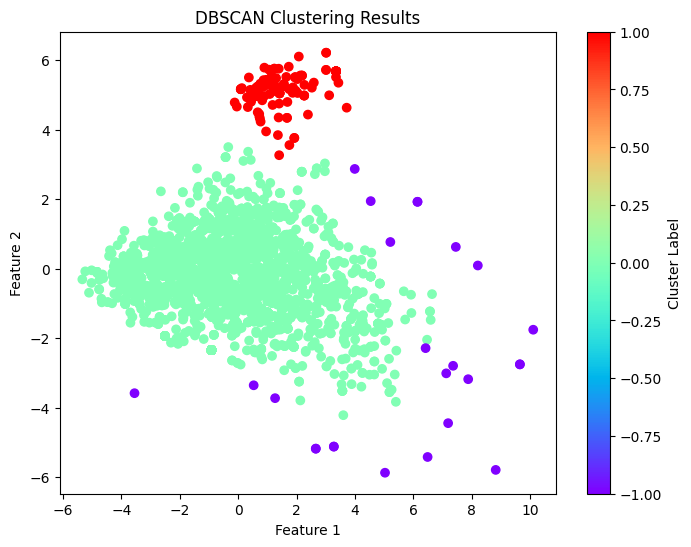

In [59]:
import matplotlib.pyplot as plt
# Step 3: Count the number of points in each cluster
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
cluster_sizes = dict(zip(unique_labels, counts))

# Display the count of points in each cluster
print("Cluster Sizes:", cluster_sizes)

# Optional: Visualize the clustering results
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='rainbow', marker='o')
plt.title('DBSCAN Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()


- We have 25 texts as outliers, 1881 texts classified as cluster 0 and 122 texts classified as cluster 1
- The sihouette score was 0.44 which indicates a moderate level of clustering quality. 

## K means comparision with DBSCAN

In [53]:
from sklearn.cluster import KMeans

# Step 4: Perform clustering using KMeans and evaluate silhouette scores
best_silhouette_score = -1
best_n_clusters = 0
n_clusters_range = range(2, 8)  # You can adjust this range as needed

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(reduced_embeddings)
    silhouette_avg = silhouette_score(reduced_embeddings, cluster_labels)
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.4f}")

    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

# Print the best silhouette score and the corresponding number of clusters
print(f"\nBest Silhouette Score: {best_silhouette_score:.4f} achieved with {best_n_clusters} clusters.")


Number of clusters: 2, Silhouette Score: 0.3798
Number of clusters: 3, Silhouette Score: 0.4211
Number of clusters: 4, Silhouette Score: 0.4043
Number of clusters: 5, Silhouette Score: 0.3676
Number of clusters: 6, Silhouette Score: 0.3962
Number of clusters: 7, Silhouette Score: 0.3942

Best Silhouette Score: 0.4211 achieved with 3 clusters.


Since all silhouette scores of k means are below the best silhouette score of DBSCAN, we used DBSCAN

In [60]:
df = pd.DataFrame({
    'Query': listOfQueries,
    'Cluster': cluster_labels
})
df.head(4)

,Query,Cluster
0,jake peyton,0
1,bush drinking video,0
2,cant stop scratching my vagina,0
3,vid idiots,0


In [67]:
df[df['Cluster']==0][:6]

,Query,Cluster
0,jake peyton,0
1,bush drinking video,0
2,cant stop scratching my vagina,0
3,vid idiots,0
4,naruto websites,0
5,eruption-van halen,0


In [68]:
df[df['Cluster']==-1][:6]

,Query,Cluster
71,washing white briefs,-1
75,monkey smells finger from ass and falls off tree,-1
106,juggernaut,-1
107,juggernaut,-1
108,x-men3 video game trailer,-1
290,sandra bernhard and madonna,-1


In [66]:
df[df['Cluster']==1][:8]

,Query,Cluster
59,www.hotgay,1
60,www.pistols,1
95,members.purelyblue.net,1
101,welcome to silent hill .com,1
134,myspace. movie,1
162,www.lifeischange.com,1
177,www.x men3.com,1
178,www.x men3.com,1


- Cluster 1 for URLs
- Cluster 0 for searching queries
- Cluster -1 are outliers

## Words Classification
- TFIDF is a statistical technique that represents texts by counting words occurences.
- It calculates a score based on the frequency of each word in a document and its rarity across all documents, giving more weight to important, unique words.
- It treats each word independently and does not capture context.

Removing stop words, tokenization, lower case

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/naka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/naka/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [19]:
# Function to filter out stop words and convert tokens to lowercase
import contractions

def filter_stopwords(queries):
    filtered_queries = []
    filtered_tokens_list=[]
    for query in queries:
        expanded_query = contractions.fix(query)
        # Tokenize the query
        tokens = word_tokenize(expanded_query)
        # Convert each token to lowercase and filter out stop words
        filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
        # Join the filtered tokens back into a string
        filtered_queries.append(" ".join(filtered_tokens))
        filtered_tokens_list.append(filtered_tokens)
    return filtered_queries,filtered_tokens_list

# Filter stop words fro
m queries
filtered_queries,filtered_tokens_list = filter_stopwords(listOfQueries)

In [79]:
filtered_queries[:5]

['jake peyton',
 'bush drinking video',
 'stop scratching vagina',
 'vid idiots',
 'naruto websites']

Visualize the distribution of TFIDF

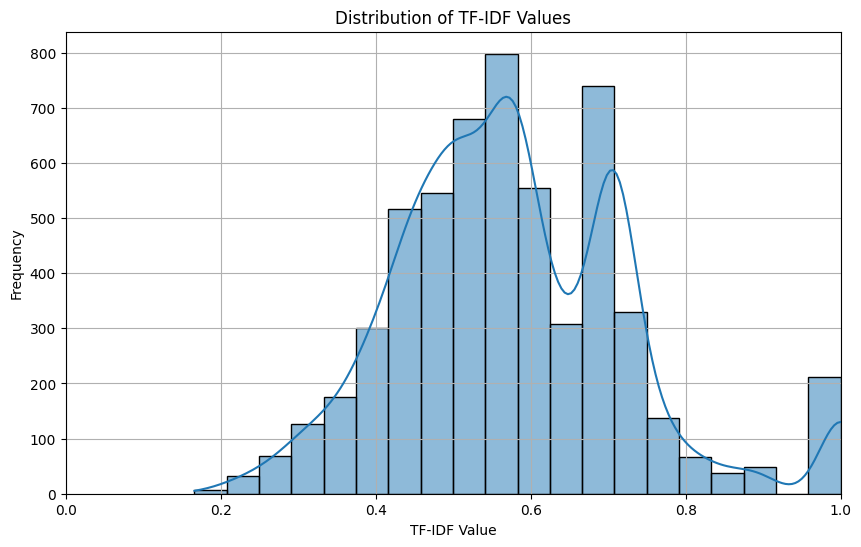

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_queries)

# Convert TF-IDF matrix to dense format
dense_tfidf = tfidf_matrix.toarray()

# Flatten the dense matrix to a 1D array
flattened_tfidf = dense_tfidf.flatten()

# Remove zero values for better visualization
non_zero_tfidf = flattened_tfidf[flattened_tfidf > 0]

# Plotting the distribution of TF-IDF values
plt.figure(figsize=(10, 6))
sns.histplot(non_zero_tfidf, bins=20, kde=True)  # kde=True adds a density estimate
plt.title('Distribution of TF-IDF Values')
plt.xlabel('TF-IDF Value')
plt.ylabel('Frequency')
plt.xlim(0, non_zero_tfidf.max())  # Limit x-axis to max TF-IDF value for better visualization
plt.grid()
plt.show()


- A TF-IDF value close to 1 indicates that a term is very relevant to a specific document while being less common across the corpus. Conversely, lower values suggest that a term is either more common across multiple documents or less relevant to the specific document.


In [83]:
n_components = 2  # Number of dimensions to reduce to
pca = PCA(n_components=n_components)
reduced_tfidf = pca.fit_transform(dense_tfidf)

### Perform cross validation for DBSCAN

In [84]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# Example values to test for min_samples
min_samples_list = range(2, 15)  # or any range suitable for your data
eps_values = [0.3, 0.5, 0.7]  # different epsilon values to test
best_score = -1
best_params = (None, None)

for eps in eps_values:
    for min_samples in min_samples_list:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(reduced_tfidf)
        
        # Calculate the silhouette score (ignore noise points)
        if len(set(labels)) > 1:  # ensure there is more than one cluster
            score = silhouette_score(reduced_embeddings, labels)
            if score > best_score:
                best_score = score
                best_params = (min_samples, eps)

print(f'Best silhouette score: {best_score} with min_samples: {best_params[0]} and eps: {best_params[1]}')


Best silhouette score: -0.001206349115818739 with min_samples: 2 and eps: 0.5


The negative silhouette score is very bad. I will try K means

In [87]:
from sklearn.cluster import KMeans

# Step 4: Perform clustering using KMeans and evaluate silhouette scores
best_silhouette_score = -1
best_n_clusters = 0
n_clusters_range = range(2, 8)  # You can adjust this range as needed

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(reduced_tfidf)
    silhouette_avg = silhouette_score(reduced_embeddings, cluster_labels)
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.4f}")

    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

# Print the best silhouette score and the corresponding number of clusters
print(f"\nBest Silhouette Score: {best_silhouette_score:.4f} achieved with {best_n_clusters} clusters.")


Number of clusters: 2, Silhouette Score: -0.0012
Number of clusters: 3, Silhouette Score: -0.1074
Number of clusters: 4, Silhouette Score: -0.2782
Number of clusters: 5, Silhouette Score: -0.3514
Number of clusters: 6, Silhouette Score: -0.3994
Number of clusters: 7, Silhouette Score: -0.3941

Best Silhouette Score: -0.0012 achieved with 2 clusters.


- The TDIDF perform very bad on k means and DBClustering. I will try the LDA

## LDA

In [24]:
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel

# Define the function to compute coherence scores for different numbers of topics
def compute_coherence_scores(corpus, dictionary, texts, max_topics=10):
    coherence_scores = []
    for num_topics in range(2, max_topics + 1):
        lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((num_topics, coherence_score))
        print(f"Num Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")
    return coherence_scores

# Create the Document-Term Matrix using CountVectorizer
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(filtered_queries)  # `filtered_queries` should be a list of preprocessed query strings

# Convert DTM to a format compatible with Gensim (list of lists of (id, count) tuples)
corpus = [[(word_id, freq) for word_id, freq in zip(doc.indices, doc.data)] for doc in dtm]

# Create dictionary from the vocabulary
dictionary = gensim.corpora.Dictionary(filtered_tokens_list)  # `filtered_tokens_list` should be tokenized lists of words for each query
texts = filtered_tokens_list  # Tokenized list of lists

# Compute coherence scores and find the optimal number of topics
coherence_scores = compute_coherence_scores(corpus, dictionary, texts, max_topics=10)

# Choose the number of topics with the highest coherence score
best_num_topics = max(coherence_scores, key=lambda x: x[1])[0]
print(f"Best Number of Topics: {best_num_topics}")


Num Topics: 2, Coherence Score: 0.7778
Num Topics: 3, Coherence Score: 0.7768
Num Topics: 4, Coherence Score: 0.7712
Num Topics: 5, Coherence Score: 0.7739
Num Topics: 6, Coherence Score: 0.7758
Num Topics: 7, Coherence Score: 0.7776
Num Topics: 8, Coherence Score: 0.7776
Num Topics: 9, Coherence Score: 0.7742
Num Topics: 10, Coherence Score: 0.7789
Best Number of Topics: 10


higher coherence scores suggest a model that better captures the semantic coherence of topics.

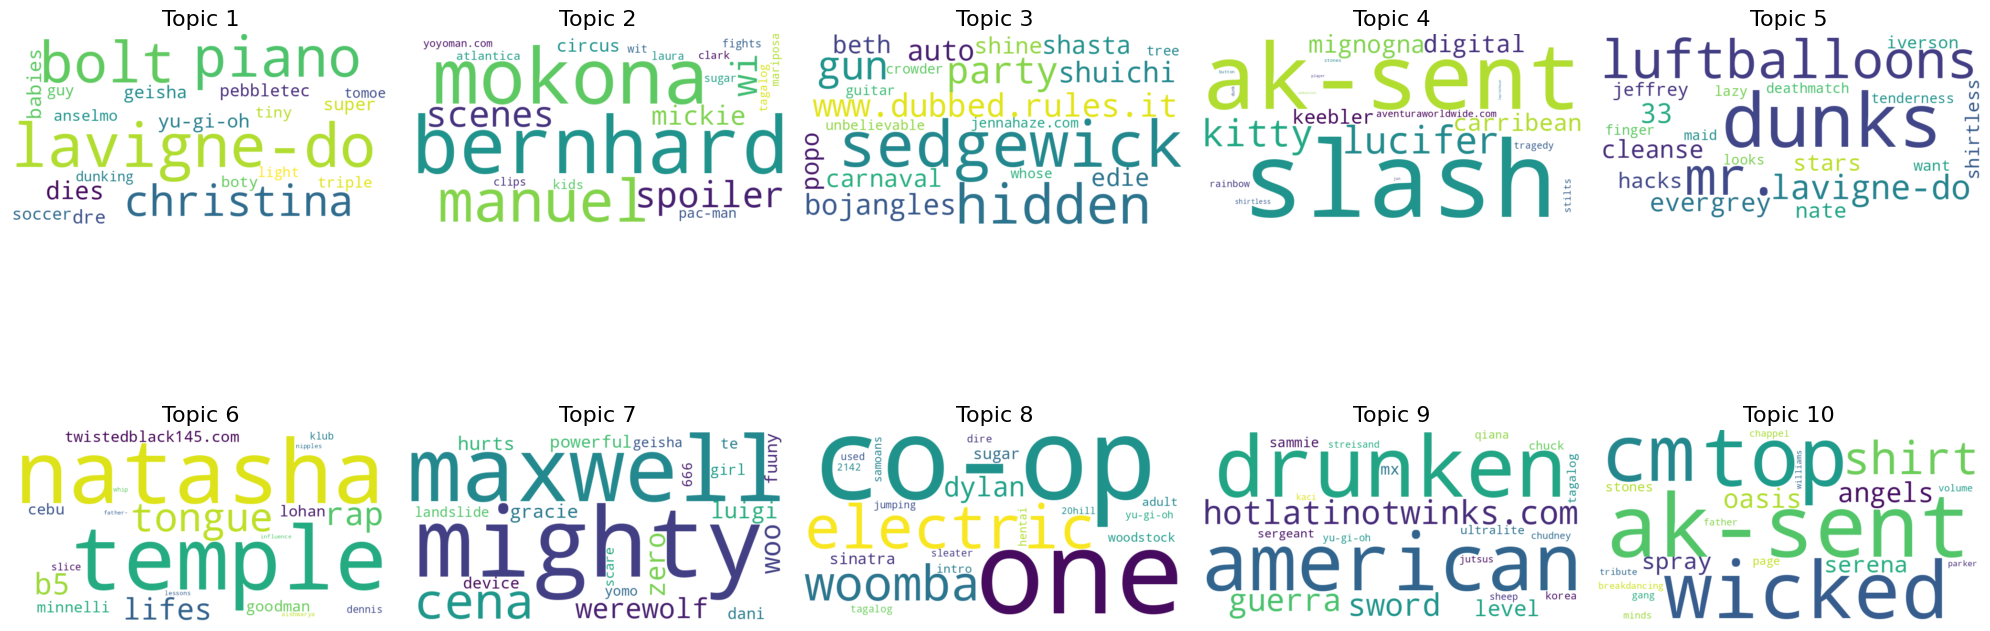

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Set up and train the LDA model with 10 topics
lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=10, id2word=dictionary, passes=15)

# Function to generate a word cloud for each topic
def plot_word_clouds(lda_model, num_topics=10):
    fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        # Extract the words and their weights for the topic
        topic_words = dict(lda_model.show_topic(i, topn=20))
        
        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
        
        # Plot the word cloud
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f"Topic {i+1}", fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Generate word clouds for each topic
plot_word_clouds(lda_model, num_topics=10)


In [29]:
# Print the top 10 words for each topic
for i, topic in lda_model.show_topics(num_topics=10, num_words=10, formatted=False):
    print(f"Topic {i+1}:")
    print(", ".join([word for word, _ in topic]))
    print("\n")


Topic 1:
lavigne-do, bolt, piano, christina, dies, babies, yu-gi-oh, dre, super, geisha


Topic 2:
bernhard, mokona, manuel, spoiler, scenes, wi, mickie, circus, pac-man, kids


Topic 3:
sedgewick, hidden, gun, party, www.dubbed.rules.it, bojangles, auto, shuichi, shasta, carnaval


Topic 4:
slash, ak-sent, lucifer, kitty, mignogna, digital, carribean, tragedy, stilts, keebler


Topic 5:
dunks, luftballoons, mr., lavigne-do, 33, evergrey, cleanse, stars, hacks, nate


Topic 6:
natasha, tongue, temple, rap, lifes, b5, twistedblack145.com, cebu, goodman, lohan


Topic 7:
mighty, maxwell, cena, werewolf, woo, zero, luigi, gracie, hurts, fuuny


Topic 8:
one, co-op, electric, woomba, dylan, sinatra, sugar, woodstock, adult, intro


Topic 9:
drunken, american, hotlatinotwinks.com, guerra, sword, level, mx, sammie, sergeant, chuck


Topic 10:
ak-sent, top, wicked, cm, shirt, angels, oasis, spray, serena, stones




- Topic 1: Pop Culture and Music Icons
- Topic 2: Gaming, Kids, and Entertainment
- Topic 3: Action and Hidden Stories
- Topic 4: Anime and Digital Culture
- Topic 5: Mixed Pop References
- Topic 6: Celebrity and Gossip
- Topic 7: Wrestling and Action Characters
- Topic 8: Music and Events
- Topic 9: Action, Military, and Intensity
- Topic 10: Fashion and Pop Style